In [1]:
import pandas as pd
import io
import requests
import numpy as np
import yfinance as yf


In [2]:
# Download ASX listed company dataset (csv format)
url = "https://asx.api.markitdigital.com/asx-research/1.0/companies/directory/file?access_token=83ff96335c2d45a094df02a206a39ff4"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

# Place in DataFrame
df = pd.DataFrame(df)

In [3]:
# Clean Dataframe and set values to numeric
df['market_cap'] = df['Market Cap']
values_to_drop = ['SUSPENDED', '--']
df = df[~df['market_cap'].isin(values_to_drop)]
df['market_cap'] = pd.to_numeric(df['market_cap'])
df = df.dropna(subset='market_cap')
df

,ASX code,Company name,GICs industry group,Listing date,Market Cap,market_cap
0,10X,EXULTANT MINING LIMITED,Materials,11/12/2025,6882000,6882000
1,14D,1414 DEGREES LIMITED,Capital Goods,12/09/2018,9301550,9301550
2,1AD,ADALTA LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",22/08/2016,13771614,13771614
3,1AE,AURORA ENERGY METALS LIMITED,Materials,18/05/2022,20592330,20592330
4,1AI,ALGORAE PHARMACEUTICALS LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",01/09/2004,28708932,28708932
...,...,...,...,...,...,...
1849,ZLD,ZELIRA THERAPEUTICS LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",28/07/2003,4282976,4282976
1850,ZMI,ZINC OF IRELAND NL,Materials,18/09/2007,7566139,7566139
1851,ZMM,ZIMI LIMITED,Technology Hardware & Equipment,10/09/2007,5293357,5293357
1852,ZNC,ZENITH MINERALS LIMITED,Materials,29/05/2007,51600865,51600865


In [4]:
# Extract ASX ticker codes, add in AXJO (ASX Market ticker) to download individual stock prices and market data.
codes = []
for x in df['ASX code']:
    codes.append(x + '.AX')
codes.insert(0, '^AXJO')

In [5]:
# Use yfinance (free api) and download stock price and market data. Set the period to the most recent 5 years (for later 5 year beta calculation). Explicitly use Adj Close data.
prices = yf.download(codes, period='5y', auto_adjust=False, multi_level_index=False)['Adj Close']
prices.index = pd.to_datetime(prices.index)
prices = pd.DataFrame(prices)

[******                12%                       ]  209 of 1799 completed$EM2N.AX: possibly delisted; no price data found  (period=5y)
[************          26%                       ]  472 of 1799 completed$JATN.AX: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")
[**********************47%                       ]  844 of 1799 completed$TERN.AX: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")
[**********************48%                       ]  862 of 1799 completed$CNJN.AX: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")
[**********************71%*********              ]  1277 of 1799 completed$AGIE.AX: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")
[**********************98%********************** ]  1763 of 1799 completed$HTMNA.AX: possibly delist

In [ ]:
# Calculate the returns
returns = np.log(prices / prices.shift(1))

# Filter out companies with too much missing data (returns). Note this will include recently added companies.
# Set minimum observations (1 year = 252 trading days)
min_observations = 252 

# Filter with valid tickers (must meet threshold OR be the market index)
valid_counts = returns.count()
valid_tickers = valid_counts[valid_counts >= min_observations].index.tolist()
dropped_tickers = valid_counts[valid_counts < min_observations].index.tolist()
returns = returns[valid_tickers]

# Output the dropped tickers to a csv file for reference
pd.DataFrame(dropped_tickers, columns=['Dropped Ticker']).to_csv('insufficient_data_tickers.csv', index=False)
print(f"Filter Complete: Removed {len(dropped_tickers)} tickers with < {min_observations} days of data.")
print(f"Proceeding with {len(valid_tickers)} tickers.")

# Calculate covariance
covariance = returns.cov() * 252

# Calculate market variance
market_variance = returns['^AXJO'].var() * 252

# Calculate Beta
# We only need the covariance of each stock against the Market (^AXJO)
covariance_with_market = covariance[['^AXJO']]

betas = covariance_with_market / market_variance

# Formatting output
betas = betas.rename(columns={'^AXJO': 'beta'}) # Rename column for clarity
betas = betas['beta']
betas.index.names = ['ASX Codes']

# Preview
betas.head()

/opt/anaconda3/envs/datasci/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Filter Complete: Removed 122 tickers with < 252 days of data.
Proceeding with 1677 tickers.


ASX Codes
14D.AX    0.277690
1AD.AX    0.620280
1AE.AX    1.211016
1AI.AX    0.427578
1CG.AX    0.742709
Name: beta, dtype: float64

In [7]:
# Remove the '.AX' suffix so it matches the 'ASX code' in the main df
betas.index = betas.index.str.replace('.AX', '', regex=False)

# Join the Beta data to the original DataFrame (df) on 'ASX code' using 'inner' join.
data_frame = df.join(betas, on='ASX code', how='inner')
data_frame.rename(columns={'^AXJO':'beta'}, inplace=True)

# Check the result
data_frame.head()

,ASX code,Company name,GICs industry group,Listing date,Market Cap,market_cap,beta
1,14D,1414 DEGREES LIMITED,Capital Goods,12/09/2018,9301550,9301550,0.277690
2,1AD,ADALTA LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",22/08/2016,13771614,13771614,0.620280
3,1AE,AURORA ENERGY METALS LIMITED,Materials,18/05/2022,20592330,20592330,1.211016
4,1AI,ALGORAE PHARMACEUTICALS LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",01/09/2004,28708932,28708932,0.427578
5,1CG,ONE CLICK GROUP LIMITED,Capital Goods,28/04/2017,13072861,13072861,0.742709


In [8]:
# Calculate Industry Weight (using Market Cap) and the Industry Beta.

# Calculate the Market Capitalisation by GICs industry group
industry_totals = data_frame.groupby('GICs industry group')['market_cap'].sum()
data_frame['industry_cap'] = data_frame['GICs industry group'].map(industry_totals)

# Calculate Industry Weight
data_frame['industry_weight'] = data_frame['market_cap'] / data_frame['industry_cap']

# Calculate the Industry Beta
data_frame['weighted_beta'] = data_frame['beta'] * data_frame['industry_weight']
industry_beta = data_frame.groupby('GICs industry group')['weighted_beta'].sum()

# Map the Industry Beta to the data_frame
data_frame['industry_beta'] = data_frame['GICs industry group'].map(industry_beta)
data_frame


,ASX code,Company name,GICs industry group,Listing date,Market Cap,market_cap,beta,industry_cap,industry_weight,weighted_beta,industry_beta
1,14D,1414 DEGREES LIMITED,Capital Goods,12/09/2018,9301550,9301550,0.277690,92779037735,0.000100,2.783973e-05,0.909957
2,1AD,ADALTA LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",22/08/2016,13771614,13771614,0.620280,104138713167,0.000132,8.202766e-05,0.846439
3,1AE,AURORA ENERGY METALS LIMITED,Materials,18/05/2022,20592330,20592330,1.211016,1009891818903,0.000020,2.469337e-05,1.075026
4,1AI,ALGORAE PHARMACEUTICALS LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",01/09/2004,28708932,28708932,0.427578,104138713167,0.000276,1.178746e-04,0.846439
5,1CG,ONE CLICK GROUP LIMITED,Capital Goods,28/04/2017,13072861,13072861,0.742709,92779037735,0.000141,1.046501e-04,0.909957
...,...,...,...,...,...,...,...,...,...,...,...
1849,ZLD,ZELIRA THERAPEUTICS LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",28/07/2003,4282976,4282976,-0.112756,104138713167,0.000041,-4.637366e-06,0.846439
1850,ZMI,ZINC OF IRELAND NL,Materials,18/09/2007,7566139,7566139,0.108566,1009891818903,0.000007,8.133778e-07,1.075026
1851,ZMM,ZIMI LIMITED,Technology Hardware & Equipment,10/09/2007,5293357,5293357,0.435596,10828407429,0.000489,2.129368e-04,1.056030
1852,ZNC,ZENITH MINERALS LIMITED,Materials,29/05/2007,51600865,51600865,0.665800,1009891818903,0.000051,3.401937e-05,1.075026


In [9]:
print(industry_beta)
print(industry_beta.mean())

GICs industry group
Automobiles & Components                          1.131153
Banks                                             1.001481
Capital Goods                                     0.909957
Class Pend                                        1.669719
Commercial & Professional Services                0.780011
Consumer Discretionary Distribution & Retail      0.982552
Consumer Durables & Apparel                       1.093808
Consumer Services                                 0.936359
Consumer Staples Distribution & Retail            0.503097
Energy                                            1.028287
Equity Real Estate Investment Trusts (REITs)      1.046557
Financial Services                                1.314143
Food, Beverage & Tobacco                          0.641431
Health Care Equipment & Services                  0.724008
Household & Personal Products                     0.528506
Insurance                                         0.739700
Materials                           

In [10]:
print(data_frame['market_cap'].sort_values(ascending=False).head(10))

368     256876471953
284     250745943450
1170    182992920857
1779    131647474209
1159    129940264749
149     112489900186
1789     94217113597
474      85037336340
1128     78670780240
696      70046451885
Name: market_cap, dtype: int64


In [11]:
# Get the 10 rows with the largest 'market_cap'
top_10 = data_frame.nlargest(10, 'market_cap')

print(top_10)

     ASX code                     Company name  \
368       CBA  COMMONWEALTH BANK OF AUSTRALIA.   
284       BHP                BHP GROUP LIMITED   
1170      NEM              NEWMONT CORPORATION   
1779      WBC      WESTPAC BANKING CORPORATION   
1159      NAB  NATIONAL AUSTRALIA BANK LIMITED   
149       ANZ       ANZ GROUP HOLDINGS LIMITED   
1789      WES               WESFARMERS LIMITED   
474       CSL                      CSL LIMITED   
1128      MQG          MACQUARIE GROUP LIMITED   
696       FMG                    FORTESCUE LTD   

                                 GICs industry group Listing date  \
368                                            Banks   12/09/1991   
284                                        Materials   13/08/1885   
1170                                       Materials   27/10/2023   
1779                                           Banks   18/07/1970   
1159                                           Banks   31/01/1962   
149                                

In [13]:
# Save the datasets to csv files
industry_beta.to_csv('industry_betas.csv')
prices.to_csv('stock_prices.csv')
data_frame.to_csv('stocks_with_betas_weights.csv')

print('Saved to CSV.')

Saved to CSV.


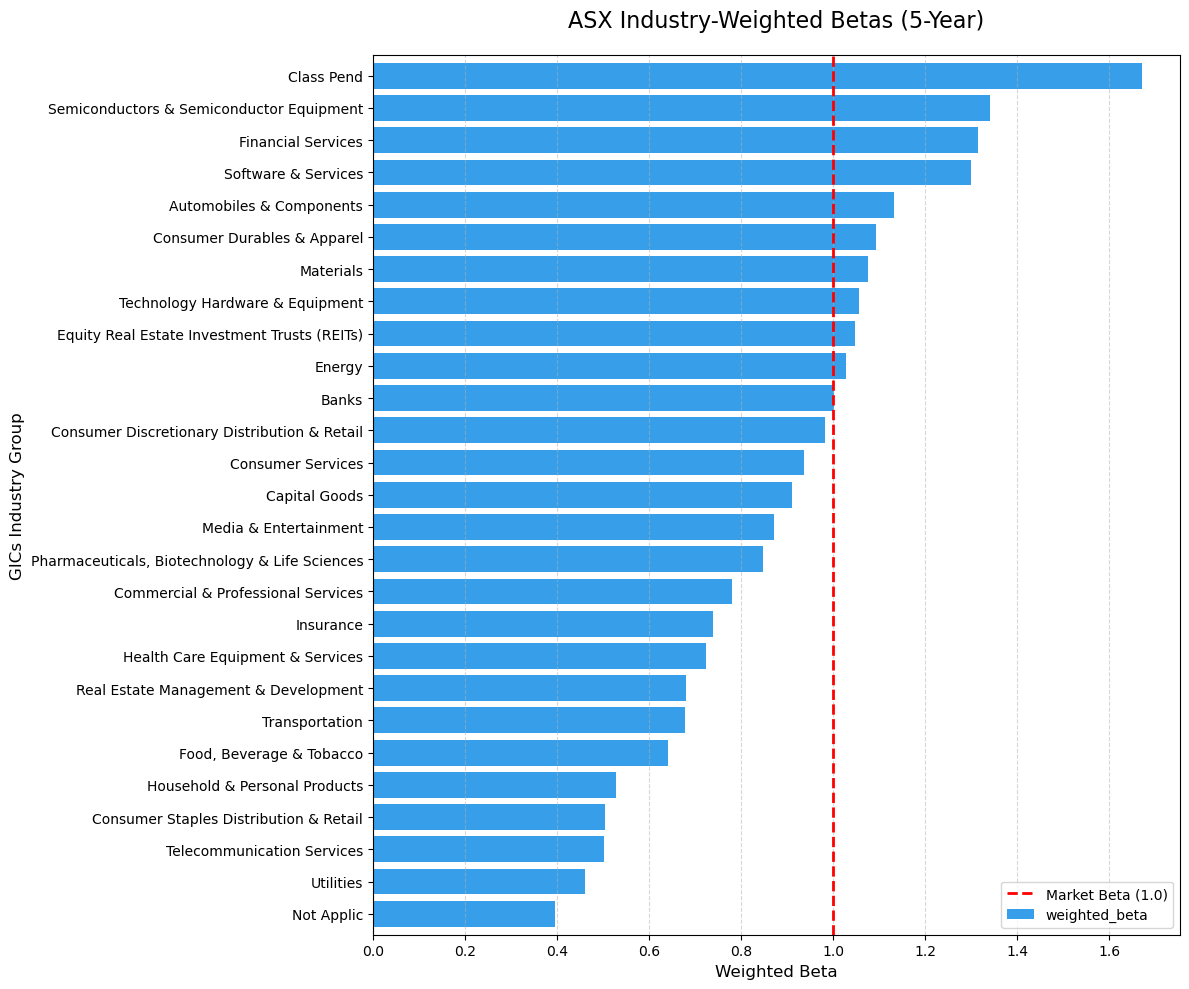

In [15]:
import matplotlib.pyplot as plt

# 1. Sort the Industry Beta data for a cleaner visual hierarchy
industry_beta_sorted = industry_beta.sort_values()

# 2. Create the Horizontal Bar Chart
plt.figure(figsize=(12, 10))
industry_beta_sorted.plot(kind='barh', color="#379fe9", width=0.8)

# 3. Add a reference line for the Market Beta (1.0)
plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Market Beta (1.0)')

# 4. Styling and Labels
plt.title('ASX Industry-Weighted Betas (5-Year)', fontsize=16, pad=20)
plt.xlabel('Weighted Beta', fontsize=12)
plt.ylabel('GICs Industry Group', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()

# 5. Save the image (Optional) and Show
plt.savefig('industry_beta_chart.png')
plt.show()